In [1]:
# Set up Python packages for Colab Workbook

%%capture
%pip install pandas
!pip install -q xlrd


In [2]:
# Import the packages

import pandas as pd
from os import walk
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Connect to the Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Navigate to the folder

%%capture
# Now, grab the data from Google Drive.

%cd /content/drive/MyDrive/Stats_cleaned/MDL_Yearly_Statistics/

In [5]:
# Here we will analyze all the Excel sheets to get (A) a list of column headers
# in each year and (B) the columns that overlap for all years

# Check which files are in the directory

filenames = next(walk('/content/drive/MyDrive/Stats_cleaned/MDL_Yearly_Statistics/'), (None, None, []))[2]

print(filenames)

cols_by_year = {}

header_list = []
filenames = [ x for x in filenames if x.endswith('.xlsx')]
bad_cols = [' ', ' .1', ' .2', ' .3', ' .4', ' .5', ' .6', ' .7', ' .8', ' .9',\
            ' .10', ' .11', ' .12', ' .13', 'unnamed: 12','category of question posed [row 2]',\
            'category of question posed [row 3]', 'category of question posed [row 4]']
print(filenames)

dataframes = {}

for file in filenames:

  df = pd.read_excel(file)
  df.columns = map(str.lower, df.columns)
  df['original_file'] = [file]*len(df)

  # Force to lowercase

  lowered_cols = [x.lower() for x in list(df)]

  # Now clean the list because it has numbers for all columns with drop-down
  # options even if it is not populated with data

  cleaned = [ x for x in lowered_cols if not (x in bad_cols) ]

  cleaned2 = []

  for col_name in cleaned:

    if col_name == 'original or published data? (original: data that they or an associate created)' \
    or col_name == 'original or published data? ( using own data (data not available to anyone else that they or associates built)'\
    or col_name == 'original or published data? ( using own data (data not available to anyone else that they or associates built) or published data (eg. dmti, stats canada, etc.)':
      cleaned2.append('original or published data?')

    if col_name ==  'department/school':
      cleaned2.append('department/school (or members of the public)')

    if col_name == 'subject.1':
      cleaned2.append('subject')
    else:
      if col_name != 'original or published data? (original: data that they or an associate created)' and col_name != 'original or published data? ( using own data (data not available to anyone else that they or associates built) or published data (eg. dmti, stats canada, etc.)':
        cleaned2.append(col_name)


  df = df.reindex(columns=cleaned2)
  cols_by_year[file] = cleaned2

  dataframes[file] = df

  header_list.append(cleaned)

cols_in_all = list(set.intersection(*map(set, header_list)))
print(cols_in_all)

dataframes2 = {}
header_set = list(set([j for i in cleaned2 for j in i]))
for h in header_set:
  for k,v in dataframes.items():

    if h not in list(v):
      v[h] = [np.nan]*len(v)
  dataframes2[k] = v


# Now write a new csv file with a lookup table with all the columns for each
# year
df_cols_lookup = pd.DataFrame.from_dict(cols_by_year, orient='index')

df_cols_lookup.to_csv('columns_lookup.csv',sep=',')

list_of_df = []
count = 0
for k,v in dataframes.items():
  v = v.reset_index(allow_duplicates = False,drop=True)[['type of question', 'timestamp', 'name', 'original_file', 'how many?']]
  v.index = v.index + count
  list_of_df.append(v)
  count += len(v)

main_df = list_of_df[0]
new_df_merged = pd.concat(list_of_df)
new_df_merged.to_csv('merge_files_common_columns2.csv')

list_of_df = []
count = 0
for k,v in dataframes2.items():
  v = v.reset_index(allow_duplicates = False,drop=True)
  v.index = v.index + count
  list_of_df.append(v)
  count += len(v)

main_df = list_of_df[0]
new_df_merged = pd.concat(list_of_df)
new_df_merged.to_csv('merge_files_all_columns2.csv')

['2013_2014.xlsx', '2011_2012.xlsx', '2016_2017.xlsx', '2017_2018.xlsx', '2019_2020.xlsx', '2018_2019.xlsx', '2021_2022.xlsx', '2022_2023.xlsx', '2020_2021.xlsx', '2015_2016.xlsx', '2014_2015.xlsx', 'merge_files_all_columns.csv', 'merge_files_common_columns.csv', 'columns_lookup.csv', 'merge_files_all_columns2.csv', 'merge_files_common_columns2.csv', 'locations.txt']
['2013_2014.xlsx', '2011_2012.xlsx', '2016_2017.xlsx', '2017_2018.xlsx', '2019_2020.xlsx', '2018_2019.xlsx', '2021_2022.xlsx', '2022_2023.xlsx', '2020_2021.xlsx', '2015_2016.xlsx', '2014_2015.xlsx']
['timestamp', 'name', 'original_file', 'how many?', 'type of question']


In [6]:
# Look at timestep because it's contained in each of the Excel files
# Question: Accross all years, when are the most questions answered?

months_dict = {}

for key, value in dataframes.items():

  value.columns = map(str.lower, value.columns)

  list_timestamps = list(value['timestamp'].dt.month)


  months_dict[key] = list_timestamps


months_count_dict = {}

for key, value in months_dict.items():

  months_count = []

  for m in list(range(1,12+1)):

    months_count.append(value.count(m))

  months_count_dict[key] = months_count

df_merge_month = pd.DataFrame.from_dict(months_count_dict)

df_merge_month.loc['Total'] = df_merge_month.sum()

df_merge_month['Month'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug',\
                           'Sep','Oct','Nov','Dec','NA']
#print(df_merge_month)

# Convert to percentages
max_months = []
for col in list(df_merge_month):
  if col != 'Month':
    list_of_months = list(df_merge_month[col])[:-2]
    div_by_total = [x / list(df_merge_month[col])[-1] *100 for x in list_of_months]
    max_index = div_by_total.index(max(div_by_total))
    months = list(df_merge_month['Month'])
    max_month = months[max_index]
    percent = round(div_by_total[max_index],2)
    max_months.append(max_month)

    print('The most questions were answered in %s for the period %s with %s percent of questions being answered in that month'%(max_month,\
                                                               col[:-5],percent))


m_count = [max_months.count(x) for x in set(max_months)]
idx_count = m_count.index(max(m_count))
c_month = list(set(max_months))[idx_count]


print('Overall, the most questions are answered in %s over all years.'%(c_month))


The most questions were answered in Nov for the period 2013_2014 with 12.59 percent of questions being answered in that month
The most questions were answered in Sep for the period 2011_2012 with 12.98 percent of questions being answered in that month
The most questions were answered in Jan for the period 2016_2017 with 12.71 percent of questions being answered in that month
The most questions were answered in Jan for the period 2017_2018 with 14.75 percent of questions being answered in that month
The most questions were answered in Oct for the period 2019_2020 with 24.42 percent of questions being answered in that month
The most questions were answered in Jan for the period 2018_2019 with 13.01 percent of questions being answered in that month
The most questions were answered in Sep for the period 2021_2022 with 11.99 percent of questions being answered in that month
The most questions were answered in Sep for the period 2022_2023 with 12.02 percent of questions being answered in tha

['SLA', 'Janina', 'Marcel (while on leave)', 'Gerald', 'Leanne', 'Marcel', 'Jordan', 'GSLA', 'Berenica', 'Nadia', 'Kelly', 'Laure', 'nan', 'Lise', 'Nick', 'Dylanne', 'Matt', 'Kara', 'Jasmine', 'Sadia', 'Leslie', 'Nich']
['SLA', 'Janina', 'Marcel (while on leave)', 'Gerald', 'Leanne', 'Marcel', 'Jordan', 'GSLA', 'Berenica', 'Nadia', 'Kelly', 'Laure', 'nan', 'Lise', 'Nick', 'Dylanne', 'Matt', 'Kara', 'Jasmine', 'Sadia', 'Leslie', 'Nich']
['SLA', 'Janina', 'Marcel (while on leave)', 'Gerald', 'Leanne', 'Marcel', 'Jordan', 'GSLA', 'Berenica', 'Nadia', 'Kelly', 'Laure', 'nan', 'Lise', 'Nick', 'Dylanne', 'Matt', 'Kara', 'Jasmine', 'Sadia', 'Leslie', 'Nich']
['SLA', 'Janina', 'Marcel (while on leave)', 'Gerald', 'Leanne', 'Marcel', 'Jordan', 'GSLA', 'Berenica', 'Nadia', 'Kelly', 'Laure', 'nan', 'Lise', 'Nick', 'Dylanne', 'Matt', 'Kara', 'Jasmine', 'Sadia', 'Leslie', 'Nich']
['SLA', 'Janina', 'Marcel (while on leave)', 'Gerald', 'Leanne', 'Marcel', 'Jordan', 'GSLA', 'Berenica', 'Nadia', 'Kelly

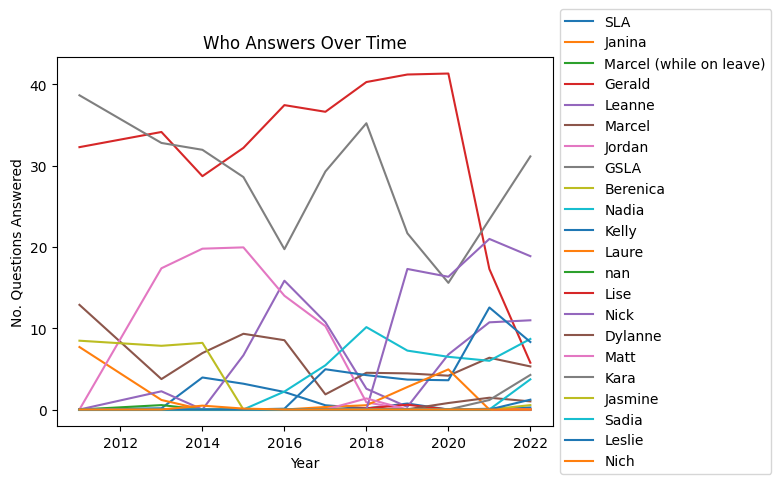

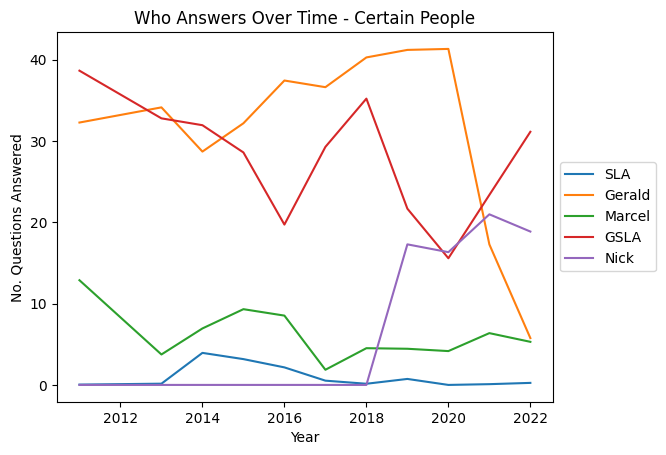

In [88]:
# Look at name because it's contained in each of the Excel files
# Question: Accross all years, who answers the questions through time?

people_dict = {}
people_list = []
for key, value in dataframes.items():

  value.columns = map(str.lower, value.columns)

  list_people = list(value['name'])


  people_dict[key] = list_people
  for person in list(set(list_people)):
    if person not in people_list:
      people_list.append(person)

people_count_dict = {}

for key, value in people_dict.items():

  people_count = []

  people_list = [str(p) for p in people_list]
  people_list = [p for p in people_list if p != '2022-10-03 16:54:08.443000']
  print(people_list)
  for p in people_list: # Get rid of the datetime someone entered as their name
      #if ~pd.isna(p) and p != 'nan' and p != '2022-10-03 16:54:08.443000':
        people_count.append(value.count(p))

  people_count_dict[key] = people_count


df_merge_people = pd.DataFrame.from_dict(people_count_dict)
years = [int(x[0:4]) for x in list(df_merge_people) if x != 'Name']
new_col = years


df_merge_people.columns = new_col
df_merge_people_save = df_merge_people.copy()
for c in new_col:
  df_merge_people[c] = df_merge_people[c] / sum(df_merge_people[c]) * 100
df_merge_people = df_merge_people.reindex(sorted(df_merge_people.columns), axis=1)
df_merge_people['Name'] = people_list
df_merge_people = df_merge_people[~pd.isna(df_merge_people['Name'])]
df_merge_people['sum'] = df_merge_people_save.sum(axis=1, numeric_only=True)
print(df_merge_q.head(20))
df_merge_people.to_csv('percent_questions_people.csv',sep=',')

names = []
values = []
for idx,row in df_merge_people.iterrows():
  names.append(list(row)[-2])
  values.append(list(row)[:-2])

years_sort=list(df_merge_people)[:-2]
plt.xlabel("Year")
plt.ylabel("No. Questions Answered")
plt.title("Who Answers Over Time")
for i in range(len(names)):
    plt.plot(years_sort,values[i],label = '%s'%(names[i]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#Just a few people

names = []
values = []
for idx,row in df_merge_people.iterrows():
  if list(row)[-2] in ['SLA','GSLA','Marcel','Gerald','Nick']:
    names.append(list(row)[-2])
    values.append(list(row)[:-2])

years_sort=list(df_merge_people)[:-2]
plt.xlabel("Year")
plt.ylabel("No. Questions Answered")
plt.title("Who Answers Over Time - Certain People")
for i in range(len(names)):
    plt.plot(years_sort,values[i],label = '%s'%(names[i]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


         2011       2013       2014       2015       2016       2017  \
0   32.352941  39.821467  35.051752  43.409248  51.489471  48.863416   
1   59.558824  55.062051  59.096338  51.115712  43.323061  47.853118   
4    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2    8.088235   5.116482   5.752389   5.383023   5.110426   3.283466   
6    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
5    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
9    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
10   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
7    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3    0.000000   0.000000   0.099522   0.092017   0.077042   0.000000   
8    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

         2018       2019       2020       2021       2022         Name    sum  
0   51.291248  60.765832  92.984796  84.262295  59.2824

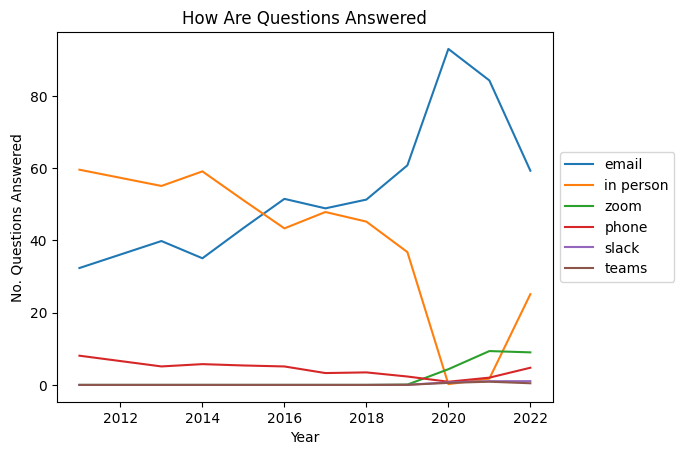

In [86]:
# Look at type of question because it's contained in each of the Excel files
# Question: Accross all years, what are the common question types?

q_dict = {}
q_list = []
for key, value in dataframes.items():
  value.columns = map(str.lower, value.columns)
  value = value[['type of question']].dropna(how='any')
  value.columns = [str(x) for x in value.columns]
  value['type of question'] = [str(i).lower() for i in list(value['type of question'])]

  #Code into categories for easier analysis

  value.loc[value['type of question'] == 'zoom consult', 'type of question'] = 'zoom'
  value.loc[value['type of question'] == 'zoom chat', 'type of question'] = 'zoom'
  value.loc[value['type of question'] == 'zoom meeting', 'type of question'] = 'zoom'
  value.loc[value['type of question'] == 'zoom session', 'type of question'] = 'zoom'
  value.loc[value['type of question'] == 'slack - helping gsla', 'type of question'] = 'slack'
  value.loc[value['type of question'] == 'zoom drop-in', 'type of question'] = 'zoom'
  value.loc[value['type of question'] == 'zoom consult + prep', 'type of question'] = 'zoom'

  value.loc[value['type of question'] == 'zoom ', 'type of question'] = 'zoom'
  value.loc[value['type of question'] == ' zoom ', 'type of question'] = 'zoom'
  value.loc[value['type of question'] == 'slack (helping gsla)', 'type of question'] = 'slack'
  value.loc[value['type of question'] == 'slack - gallup data group', 'type of question'] = 'slack'
  value.loc[value['type of question'] == 'teams call', 'type of question'] = 'teams'
  value.loc[value['type of question'] == 'slack (data viz challenge)', 'type of question'] = 'slack'
  value.loc[value['type of question'] == 'slack - working with nick', 'type of question'] = 'slack'
  value.loc[value['type of question'] == 'slack with gsla', 'type of question'] = 'slack'
  value.loc[value['type of question'] == 'slack w/ colleagues', 'type of question'] = 'slack'
  value.loc[value['type of question'] == 'slack (gsla)', 'type of question'] = 'slack'
  value.loc[value['type of question'] == 'supported via email', 'type of question'] = 'email'
  value.loc[value['type of question'] == 'the patron came to zoom first, then sent an email', 'type of question'] = 'email/zoom'
  value.loc[value['type of question'] == 'email & zoom ', 'type of question'] = 'email/zoom'
  value.loc[value['type of question'] == 'zoom & email', 'type of question'] = 'email/zoom'
  value.loc[value['type of question'] == 'zoom and e-mail ', 'type of question'] = 'email/zoom'
  value.loc[value['type of question'] == 'zoom and email', 'type of question'] = 'email/zoom'
  value.loc[value['type of question'] == 'email and zoom', 'type of question'] = 'email/zoom'
  value.loc[value['type of question'] == 'email + zoom', 'type of question'] = 'email/zoom'
  value.loc[value['type of question'] == 'ms teams', 'type of question'] = 'teams'
  value.loc[value['type of question'] == 'microsoft teams', 'type of question'] = 'teams'
  value.loc[value['type of question'] == 'ms teams chat', 'type of question'] = 'teams'
  value.loc[value['type of question'] == 'teams consult', 'type of question'] = 'teams'
  value.loc[value['type of question'] == 'slack - helping gslas', 'type of question'] = 'slack'
  value.loc[value['type of question'] == '0', 'type of question'] = 'other'
  value.loc[value['type of question'] == 'jira comments', 'type of question'] = 'email'
  value.loc[value['type of question'] == 'jira comments ', 'type of question'] = 'email'
  value.loc[value['type of question'] == 'jira comments/email ', 'type of question'] = 'email'
  value.loc[value['type of question'] == 'jira', 'type of question'] = 'email'
  value.loc[value['type of question'] == 'patron called first, and emailed, problem was solved via zoom', 'type of question'] = 'other'
  value.loc[value['type of question'] == 'jira, zoom', 'type of question'] = 'email/zoom'
  value.loc[value['type of question'] == 'this was answered in zoom reference hours, additional follow up was provided through e-mail. ', 'type of question'] = 'email/zoom'
  value.loc[value['type of question'] == 'the first part of the inquire was answered in zoom reference hours, the second part and follow up was answered through e-mail. ', 'type of question'] = 'email/zoom'
  value.loc[value['type of question'] == 'phone; email', 'type of question'] = 'phone/email'
  value.loc[value['type of question'] == 'email and phone', 'type of question'] = 'phone/email'
  value.loc[value['type of question'] == 'jira, zoom ', 'type of question'] = 'email/zoom'
  value.loc[value['type of question'] == 'webx conference call', 'type of question'] = 'webex'
  value.loc[value['type of question'] == 'webx conference call', 'type of question'] = 'webex'
  value.loc[value['type of question'] == 'zoom and telephone', 'type of question'] = 'other'

  value.loc[value['type of question'] == 'helping gsla', 'type of question'] = 'other'
  value.loc[value['type of question'] == 'did not respond directly, another gsla did', 'type of question'] = 'other'
  value.loc[value['type of question'] == 'help', 'type of question'] = 'other'
  value.loc[value['type of question'].str.contains('chat'), 'type of question'] = 'other'
  value.loc[value['type of question'] == 'bb collab and email', 'type of question'] = 'other'
  value.loc[value['type of question'] == 'zoom; teams', 'type of question'] = 'other'
  value.loc[value['type of question'] == 'email and in person', 'type of question'] = 'other'
  value.loc[value['type of question'] == 'quercus', 'type of question'] = 'other'
  value.loc[value['type of question'] == 'github', 'type of question'] = 'other'
  value.loc[value['type of question'] == 'linkedin', 'type of question'] = 'other'

  list_q = list(value['type of question'])
  list_q = [str(i).lower() for i in list_q]

  q_dict[key] = list_q
  for q in list(set(list_q)):
    if q not in q_list:
      q_list.append(q)

# Pull out common values

q_count_dict = {}

for key, value in q_dict.items():

  q_count = []


  for q in q_list: # Get rid of the datetime someone entered as their name
      q_count.append(value.count(q))

  q_count_dict[key] = q_count


df_merge_q = pd.DataFrame.from_dict(q_count_dict)
years = [int(x[0:4]) for x in list(df_merge_q) if x != 'Name']
new_col = years

df_merge_q.columns = new_col
df_merge_q_save = df_merge_q.copy()
for c in new_col:
  df_merge_q[c] = df_merge_q[c] / sum(df_merge_q[c]) * 100
df_merge_q = df_merge_q.reindex(sorted(df_merge_q.columns), axis=1)
df_merge_q['Name'] = q_list
df_merge_q = df_merge_q[~pd.isna(df_merge_q['Name'])]
df_merge_q = df_merge_q.sort_values(2022, ascending=[False])
df_merge_q['sum'] = df_merge_q_save.sum(axis=1, numeric_only=True)
print(df_merge_q.head(20))
df_merge_category.to_csv('percent_questions_type.csv',sep=',')

names = []
values = []
for idx,row in df_merge_q.iterrows():
  if list(row)[-2] in ['zoom','in person','email','phone','slack','teams']:
    names.append(list(row)[-2])
    values.append(list(row)[:-2])

years_sort=list(df_merge_q)[:-2]
plt.xlabel("Year")
plt.ylabel("No. Questions Answered")
plt.title("How Are Questions Answered")
for i in range(len(names)):
    plt.plot(years_sort,values[i],label = '%s'%(names[i]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

         2011       2013       2014       2015       2016       2017  \
0   22.893482  21.837579  23.785828  17.092248  16.358500  23.683699   
1    8.644674   4.180274   4.339172   3.956752   7.550077  10.588692   
2   15.083466  13.803614  11.863057  11.272142   8.371854   6.722363   
3   51.748808  58.632702  58.937102  61.950771  58.936826  57.586944   
4    1.629571   1.545831   1.074841   0.828157   0.564972   0.077715   
5    0.000000   0.000000   0.000000   2.645503   4.417052   0.097144   
6    0.000000   0.000000   0.000000   0.000000   0.873138   1.107441   
7    0.000000   0.000000   0.000000   2.254428   2.927581   0.136002   
8    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
21   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
34   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
35   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
58   0.000000   0.000000   0.000000   0.000000   0.000000   0.00

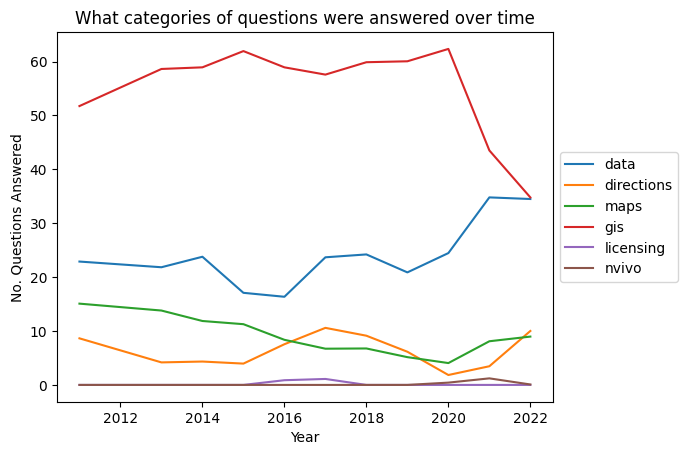

In [83]:
# Look at type of question posed & category of question posed because it's contained in each of the Excel files
# Question: Accross all years, who answers the questions through time?

category_dict = {}
category_list = []
for key, value in dataframes.items():

  value.columns = map(str.lower, value.columns)
  value.columns = [str(x) for x in value.columns]

  if 'type of question posed' in list(value):
    value = value[['type of question posed']].dropna(how='any')
    value['type of question posed'] = [str(i).lower() for i in list(value['type of question posed'])]
    value.loc[value['type of question posed'].str.contains('nvivo'), 'type of question posed'] = 'nvivo'
    value.loc[value['type of question posed'].str.contains('gis'), 'type of question posed'] = 'gis'
    value.loc[value['type of question posed'].str.contains('map'), 'type of question posed'] = 'maps'
    value.loc[value['type of question posed'].str.contains('data'), 'type of question posed'] = 'data'
    value.loc[value['type of question posed'].str.contains('license'), 'type of question posed'] = 'licensing'
    value.loc[value['type of question posed'].str.contains('directional'), 'type of question posed'] = 'directions'
    value.loc[value['type of question posed'].str.contains('statistical'), 'type of question posed'] = 'statistical support'
    list_category = list(value['type of question posed'])
  else:
    value = value[['category of question posed']].dropna(how='any')
    value['category of question posed'] = [str(i).lower() for i in list(value['category of question posed'])]
    value.loc[value['category of question posed'].str.contains('nvivo'), 'category of question posed'] = 'nvivo'
    value.loc[value['category of question posed'].str.contains('gis'), 'category of question posed'] = 'gis'
    value.loc[value['category of question posed'].str.contains('map'), 'category of question posed'] = 'maps'
    value.loc[value['category of question posed'].str.contains('data'), 'category of question posed'] = 'data'
    value.loc[value['category of question posed'].str.contains('license'), 'category of question posed'] = 'licensing'
    value.loc[value['category of question posed'].str.contains('directional'), 'category of question posed'] = 'directions'
    value.loc[value['category of question posed'].str.contains('statistical'), 'category of question posed'] = 'statistical support'
    list_category = list(value['category of question posed'])



  category_dict[key] = list_category
  for category in list(set(list_category)):
    if category not in category_list:
      category_list.append(category)

category_count_dict = {}

for key, value in category_dict.items():

  category_count = []


  for c in category_list:
        category_count.append(value.count(c))

  category_count_dict[key] = category_count


df_merge_category = pd.DataFrame.from_dict(category_count_dict)
years = [int(x[0:4]) for x in list(df_merge_category) if x != 'Name']
new_col = years


df_merge_category.columns = new_col
df_merge_category_save = df_merge_category.copy()
for c in new_col:
  df_merge_category[c] = df_merge_category[c] / sum(df_merge_category[c]) * 100
df_merge_category = df_merge_category.reindex(sorted(df_merge_category.columns), axis=1)

df_merge_category['Name'] = category_list
df_merge_category = df_merge_category[~pd.isna(df_merge_category['Name'])]
df_merge_category['sum'] = df_merge_category_save.sum(axis=1, numeric_only=True)
df_merge_category = df_merge_category[df_merge_category['sum'] > 1]
df_merge_category = df_merge_category[df_merge_category['Name'] != 'nan']
print(df_merge_category)
df_merge_category.to_csv('percent_questions_category.csv',sep=',')
#Just a few categories

names = []
values = []
for idx,row in df_merge_category.iterrows():

  if list(row)[-2] in ['data','maps','directions','gis','nvivo','licensing']:
    names.append(list(row)[-2])
    values.append(list(row)[:-2])

years_sort=list(df_merge_category)[:-2]
plt.xlabel("Year")
plt.ylabel("No. Questions Answered")
plt.title("What categories of questions were answered over time")
for i in range(len(names)):
    plt.plot(years_sort,values[i],label = '%s'%(names[i]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


          2011       2013       2014       2015       2016       2017  \
24   59.515571  70.171376  67.604533  73.382545  70.190996  78.561354   
27    6.487889   6.438166   6.135209   6.643508   5.729877   6.393982   
30   16.522491   5.419176   5.588120   2.518454   0.068213   0.376117   
33    2.162630   4.353868   2.774521   3.777681   6.480218   3.902210   
7     0.692042   2.779064   3.360688   1.476335   2.182810   3.714151   
18    2.335640   3.103289   2.852677   2.648719   2.046385   2.397743   
41    1.211073   1.760074   1.875733   1.259227   2.523874   0.846262   
32    1.038062   0.555813   2.422821   1.910551   1.500682   1.222379   
39    0.173010   1.621121   1.836655   1.997395   1.841746   1.222379   
43    1.557093   0.694766   1.719422   1.215805   0.954980   0.047015   
0     0.605536   0.370542   0.078156   0.086843   2.728513   0.000000   
10    0.000000   0.324224   0.234467   0.217108   0.886767   0.047015   
54    0.000000   0.046318   0.468933   0.173686   0

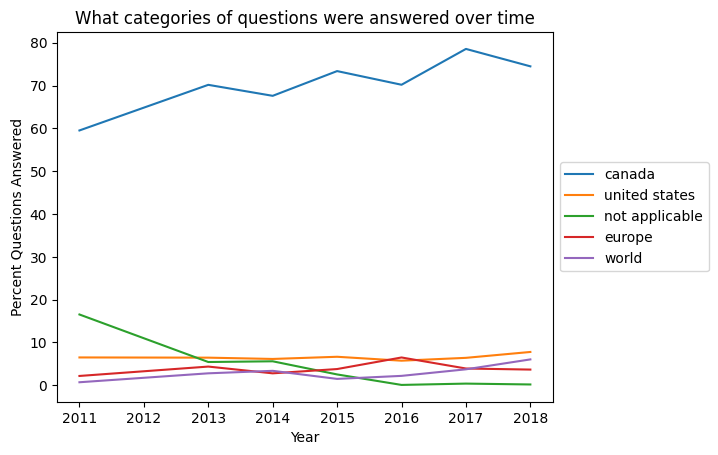

In [81]:
# Look at geography of the questions
# Question: Accross all years, where is the area of interest?

category_dict = {}
category_list = []
for key, value in dataframes.items():

  value.columns = map(str.lower, value.columns)
  value.columns = [str(x) for x in value.columns]

  if 'geography' in list(value):
    value = value[['geography']].dropna(how='any')
    value['geography'] = [str(i).lower() for i in list(value['geography'])]
    value.loc[value['geography'].str.contains('canada'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('united states'), 'geography'] = 'united states'
    value.loc[value['geography'].str.contains('pennsylvania'), 'geography'] = 'united states'
    value.loc[value['geography'].str.contains('california'), 'geography'] = 'united states'
    value.loc[value['geography'].str.contains('detroit'), 'geography'] = 'united states'
    value.loc[value['geography'].str.contains('usa'), 'geography'] = 'united states'
    value.loc[value['geography'].str.contains('us'), 'geography'] = 'united states'
    value.loc[value['geography'].str.contains('nyc'), 'geography'] = 'united states'
    value.loc[value['geography'].str.contains('texas'), 'geography'] = 'united states'
    value.loc[value['geography'].str.contains('boston'), 'geography'] = 'united states'
    value.loc[value['geography'].str.contains('chicago'), 'geography'] = 'united states'
    value.loc[value['geography'].str.contains('new york'), 'geography'] = 'united states'
    value.loc[value['geography'].str.contains('ontario'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('toronto'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('quebec'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('oakville'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('gtha'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('saskatchewan'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('vaughan'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('york region'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('newfoundland'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('vancouver'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('stormont'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('fredericton'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('whistler'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('hamilton'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('thunder bay'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('burlington'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('brampton'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('gull lake'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('cape breton'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('missisauga'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('mississauga'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('ottawa '), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('ottawa'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('waterloo'), 'geography'] = 'canada'
    value.loc[value['geography'] == 'to', 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('new brunswick'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('trca'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('caledon'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('saskatoon'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('algonquin park'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('don valley'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('guelph'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('montreal'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('alberta'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('calgary'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('bc'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('british columbia'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('niagara'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('richmond hill'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('gta'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('scarborough'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('north york'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('markham'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('pei'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('golden horseshoe'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('manitoba'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('edmonton'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('kingston'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('st laurence river'), 'geography'] = 'canada'
    value.loc[value['geography'].str.contains('world, british isles'), 'geography'] = 'uk'
    value.loc[value['geography'].str.contains('world, london, uk'), 'geography'] = 'uk'
    value.loc[value['geography'].str.contains('london, united kingdom'), 'geography'] = 'uk'
    value.loc[value['geography'].str.contains('unknown'), 'geography'] = 'unspecified'
    value.loc[value['geography'].str.contains('chiapas mexico'), 'geography'] = 'mexico'
    value.loc[value['geography'].str.contains('uganda'), 'geography'] = 'africa'
    value.loc[value['geography'].str.contains('senegal'), 'geography'] = 'africa'
    value.loc[value['geography'].str.contains('nigeria'), 'geography'] = 'africa'
    value.loc[value['geography'].str.contains('west africa'), 'geography'] = 'africa'
    value.loc[value['geography'].str.contains('ethiopia'), 'geography'] = 'africa'
    value.loc[value['geography'].str.contains('morocco'), 'geography'] = 'africa'
    value.loc[value['geography'].str.contains('south africa'), 'geography'] = 'africa'
    value.loc[value['geography'].str.contains('world, china'), 'geography'] = 'china'
    value.loc[value['geography'].str.contains('uk'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('holland'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('france'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('venezuela'), 'geography'] = 'south america'
    value.loc[value['geography'].str.contains('peru'), 'geography'] = 'south america'
    value.loc[value['geography'].str.contains('brazil'), 'geography'] = 'south america'
    value.loc[value['geography'].str.contains('sao paulo'), 'geography'] = 'south america'
    value.loc[value['geography'].str.contains('ecuador'), 'geography'] = 'south america'
    value.loc[value['geography'].str.contains('honduras'), 'geography'] = 'central america'
    value.loc[value['geography'].str.contains('world, south america'), 'geography'] = 'south america'
    value.loc[value['geography'].str.contains('latin america'), 'geography'] = 'south america'
    value.loc[value['geography'].str.contains('amazon'), 'geography'] = 'south america'
    value.loc[value['geography'].str.contains('world, papua new guinea'), 'geography'] = 'oceania'
    value.loc[value['geography'].str.contains('papua new guinea'), 'geography'] = 'oceania'
    value.loc[value['geography'].str.contains('australia'), 'geography'] = 'oceania'
    value.loc[value['geography'].str.contains('world, spain'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('paris'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('netherlands'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('spain'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('italy'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('england'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('mediterranean'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('europe'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('norway'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('germany'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('poland'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('world, finland'), 'geography'] = 'europe'
    value.loc[value['geography'].str.contains('pakistan'), 'geography'] = 'middle east'
    value.loc[value['geography'].str.contains('lebanon'), 'geography'] = 'middle east'
    value.loc[value['geography'].str.contains('iran'), 'geography'] = 'middle east'
    value.loc[value['geography'].str.contains('jordan'), 'geography'] = 'middle east'
    value.loc[value['geography'].str.contains('turkey'), 'geography'] = 'middle east'
    value.loc[value['geography'].str.contains('egypt'), 'geography'] = 'middle east'
    value.loc[value['geography'].str.contains('saudi arabia'), 'geography'] = 'middle east'
    value.loc[value['geography'].str.contains('lake erie'), 'geography'] = 'north america'
    value.loc[value['geography'].str.contains('great lakes'), 'geography'] = 'north america'
    value.loc[value['geography'].str.contains('mumbai'), 'geography'] = 'india'
    value.loc[value['geography'].str.contains('india'), 'geography'] = 'south asia'
    value.loc[value['geography'].str.contains('bangladesh'), 'geography'] = 'south asia'
    value.loc[value['geography'].str.contains('sri lanka'), 'geography'] = 'south asia'

    #Not applicable = where they answered MDL, Robarts, etc.
    value.loc[value['geography'].str.contains('arcgis'), 'geography'] = 'not applicable'
    value.loc[value['geography'].str.contains('mdl'), 'geography'] = 'not applicable'
    value.loc[value['geography'].str.contains('map and data library'), 'geography'] = 'not applicable'
    value.loc[value['geography'].str.contains('robarts'), 'geography'] = 'not applicable'
    value.loc[value['geography'].str.contains('none'), 'geography'] = 'not applicable'
    value.loc[value['geography'].str.contains('maps data library'), 'geography'] = 'not applicable'
    value.loc[value['geography'] == 'na', 'geography'] = 'not applicable'
    value.loc[value['geography'].str.contains('scanner'), 'geography'] = 'not applicable'
    value.loc[value['geography'].str.contains('course reserves'), 'geography'] = 'not applicable'
    value.loc[value['geography'] == 'any', 'geography'] = 'not applicable'
    value.loc[value['geography'] == 'nb', 'geography'] = 'canada' #New Brunswick?
    value.loc[value['geography'] == 'pq', 'geography'] = 'not applicable'

    value.loc[value['geography'] == 'on', 'geography'] = 'canada'
    value.loc[value['geography'] == 'artic', 'geography'] = 'arctic'
    value.loc[value['geography'].str.contains('mexico'), 'geography'] = 'mexico'

    #asia

    value.loc[value['geography'].str.contains('japan'), 'geography'] = 'asia'
    value.loc[value['geography'].str.contains('tokyo'), 'geography'] = 'asia'
    value.loc[value['geography'].str.contains('china'), 'geography'] = 'asia'
    value.loc[value['geography'].str.contains('indonesia'), 'geography'] = 'asia'

    value.loc[value['geography'].str.contains('global'), 'geography'] = 'world'
    value.loc[value['geography'].str.contains('world maps'), 'geography'] = 'world'

    #remaining canadian locations

    canadian_towns = [
    'Brockville', 'Sudbury', 'Barrie', 'Peterborough', 'London', 'Fort Severn', 'Christian Island, Georgian Bay',
    'Georgian Bay', 'Shelburne', 'King City', 'Pigeon Lake', 'Toronto Islands', 'East York', 'Thornhill',
    'Nobleton', 'Cardinal', 'Toronto Harbour', 'Ontario', 'Domica', 'Fenelon Falls', 'Ontario Hydro', 'Arnprior',
    'Guelph', 'St. Catharines', 'Temagami', 'Georgina', 'Penetanguishene', 'Brantford', 'Scarborough',
    'Niagara-on-the-Lake', 'Ingersoll', 'Newmarket', 'Halton Hills', 'Orillia', 'Haliburton', 'Grand Valley',
    'Dundas', 'Richmond Hill', 'Cambridge', 'Acton', 'Caledon', 'Stouffville', 'Huntsville', 'Angus', 'Tottenham',
    'Kenora', 'Collingwood', 'Listowel', 'Thorold', 'Elmira', 'Port Perry', 'Cobourg', 'Bancroft', 'Pembroke',
    'Grimsby', 'Sarnia', 'Penetang', 'King City', 'Norwich', 'Simcoe', 'Niagara Falls', 'Welland', 'Brampton',
    'Ontario County', 'Clarington', 'Don Mills', 'Tillsonburg', 'Perth', 'Woodstock', 'Orangeville', 'Gravenhurst',
    'Sault St. Marie', 'Muskoka', 'Fort Erie', 'New Tecumseth', 'Peterborough County', 'Kitchener', 'Wingham',
    'St. Thomas', 'Alliston', 'Simcoe County', 'Brant', 'Brockville', 'Huron County', 'Quinte West', 'Halton','Halton Hills',
    'Norfolk County', 'Haldimand County', 'Essex', 'Grey County', 'Wellington County', 'Dufferin County', 'Peel', 'onatrio'
    'tornoto','annex historical maps','northwest territories','junction','fort york','oshawa','northern ont','york county',
    'st lawrence river','geulph','pickering','downsview','winnipeg','toront','tornoto','onatrio','bridgetown ns','milton',
    'slate falls, lac seul','nova scotia','etobicoke','hastings','high park','kawartha lakes','ft york','pigeon river','fraser valley',
    'york','annex','port burwell','banff','north bay','prairies','cornwall','nunavut','credit valley','s ont','torotno',
    'yoho national park','southern ont','rouge valley','chatham','timmins','lambton','algonquin','king and yonge','whitehorse',
    'brandon','leaside','canadian arctic','aurora','port hope','golden horsehoe','nippising','queen charlotte islands',
    's. ont','n ont','mississauaga','regent park','nwt','cma','cma, province','rice lake ont','harbourfront'
]

    canadian_towns = [x.lower() for x in canadian_towns]

    for location in canadian_towns:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'canada'

    africa_locations = [
    'Africa', 'Kenya', 'Zimbabwe', 'Zambia', 'Rwanda', 'Rawanda','Malawi', 'Ghana', 'Mozambique', 'Madagascar',
    'botswana','cape town','morroco','burundi','madagasgar'
  ]

    africa_locations = [x.lower() for x in africa_locations]

    for location in africa_locations:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'africa'


    europe_locations = [
    'europe', 'sweden', 'greece', 'portugal', 'scotland', 'netherlands', 'slovakia', 'denmark',
    'germany', 'france', 'spain', 'italy', 'united kingdom', 'ireland', 'russia', 'croatia','florence',
    'danube river','rome','hungary','soviet union','britain','amsterdam','black sea','munich','venice',
    'morrocco','tristan da cunha','tristan de cunha','dublin'
  ]

    for location in europe_locations:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'europe'


    usa_locations = [
    'united states', 'new york','u.s.',
    'florida', 'arizona', 'oklahoma', 'ohio', 'illinois','tennessee','alaska','washington dc',
    'las vegas','basket lake'
]
    for location in usa_locations:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'united states'

      verb_values = [
    'install gis', 'unclear', 'map data lib', 'map and data lib', 'install gis', 'scanning',
    'map appraisal', 'esri courses', 'map appraisal', 'esri license file', 'uoft', 'u of t'
    'dmti consortium', 'gis location to work','spss','dmti consortium','rotmans','arcpad',
    'ggr100','qgis','u of t','utm','arcmap','test','dmti data','general','hrm','pdm'
]
    for location in verb_values:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'not applicable'

    value.loc[value['geography'].str.endswith("?"), 'geography'] = 'not applicable'
    asia_locations = [
    'asia', 'beijing', 'south asia', 'afghanistan', 'hong kong', 'tibet', 'japan',
    'thailand', 'philippines', 'vietnam','cina','korea'
  ]
    for location in asia_locations:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'asia'

    middle_east_options = [
    'middle east', 'iraq', 'syria', 'israel', 'palestine', 'united arab emirates','jordan',
    'israel','syria','palestine','iraq','azerbaijan','dubai','constantinople','khurdistan',
    'near east'
    ]

    for location in middle_east_options:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'middle east'

    south_america_locations = ['colombia', 'venezuela', 'argentina','guyana','columbia icefields',
                               'venezuala','venezeula']
    for location in south_america_locations:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'south america'

    north_america_locations = ['rockies','rocky mountains','carribean','caribbean','barbados','costa rica',
                               'haiti','national parks']
    for location in north_america_locations:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'north america'

    c_america_locations = ['cuba','dominica','nicaragua']
    for location in c_america_locations:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'central america'


    sasia_locations = ['bengal','maldives']
    for location in sasia_locations:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'south asia'

    oceania_locations = ['oceania','zealand','tasmania']
    for location in oceania_locations:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'oceania'

    ilocations = ['oecd world','oecd countries']
    for location in ilocations:

      value.loc[value['geography'].str.contains(location), 'geography'] = 'international'


    list_category = list(value['geography'])
  else:
    list_category = []




  category_dict[key] = list_category
  for category in list(set(list_category)):
    if category not in category_list:
      category_list.append(category)

category_count_dict = {}

for key, value in category_dict.items():

  category_count = []


  for c in category_list:
        category_count.append(value.count(c))

  category_count_dict[key] = category_count


df_merge_category = pd.DataFrame.from_dict(category_count_dict)
years = [int(x[0:4]) for x in list(df_merge_category) if x != 'Name']
new_col = years


df_merge_category.columns = new_col
df_merge_category_save = df_merge_category.copy()
for c in new_col:
  df_merge_category[c] = df_merge_category[c] / sum(df_merge_category[c]) * 100
df_merge_category = df_merge_category.reindex(sorted(df_merge_category.columns), axis=1)

df_merge_category['Name'] = category_list
df_merge_category = df_merge_category[~pd.isna(df_merge_category['Name'])]
df_merge_category['Sum'] = df_merge_category_save.sum(axis=1, numeric_only=True)
df_merge_category = df_merge_category[df_merge_category['Sum'] > 1]
df_merge_category = df_merge_category[df_merge_category['Name'] != 'nan']
df_merge_category = df_merge_category.sort_values('Sum', ascending=[False])
df_merge_category = df_merge_category.loc[:, ~np.all(np.equal(df_merge_category.values, 0), axis=0)]
print(df_merge_category)
df_merge_category.to_csv('percent_questions_geography.csv',sep=',')

#Just a few categories

names = []
values = []
for idx,row in df_merge_category.iterrows():

  if list(row)[-2] in ['canada','united states','world','europe','not applicable']:
    names.append(list(row)[-2])
    values.append(list(row)[:-2])

years_sort=list(df_merge_category)[:-2]
plt.xlabel("Year")
plt.ylabel("Percent Questions Answered")
plt.title("What categories of questions were answered over time")
for i in range(len(names)):
    plt.plot(years_sort,values[i],label = '%s'%(names[i]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<ipython-input-138-50ea372626be>:93: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'statistical_software'
<ipython-input-138-50ea372626be>:591: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'statistical data'
<ipython-input-138-50ea372626be>:848: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'environmental data'
<ipython-input-138-50ea372626be>:93: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  value.loc[value['subject'].s

      2011       2013       2014       2015       2016      2017       2018  \
1711   NaN  22.425430  20.222930  24.292616  29.250128  8.121236  12.694239   
1862   NaN   2.460266   3.861465   3.289625   4.057524  5.051486   7.124074   
205    NaN   4.593947   3.921178   3.588682   2.773498  2.584030   2.629692   
330    NaN   2.982800   1.970541   2.760524   2.131484  1.515446   1.864690   
976    NaN   2.373177   1.433121   2.185415   1.617874  2.078881   1.745159   
1895   NaN   0.631396   1.194268   1.150219   1.284027  1.593161   0.095625   
665    NaN   1.328108   0.955414   0.736140   0.693374  0.893724   0.908439   
917    NaN   1.698236   0.716561   0.598114   0.590652  0.388576   0.239063   
509    NaN   0.827346   0.557325   0.230044   0.410889  0.971440   0.645470   
123    NaN   0.283039   0.537420   0.230044   0.616333  0.893724   0.980158   
2475   NaN   0.000000   0.039809   0.207039   0.333847  1.126870   0.812814   
232    NaN   0.370128   0.816083   0.759144   0.6163

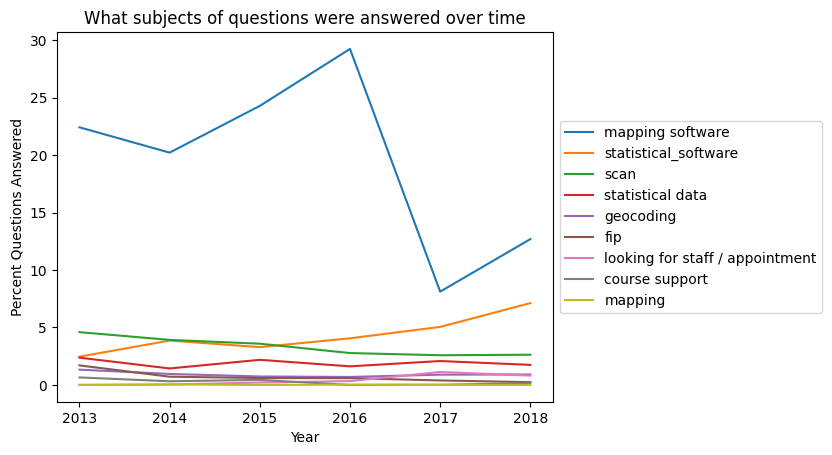

In [138]:
# Look at subject of the questions
# Question: Accross all years, what kinds of questions were answered?

category_dict = {}
category_list = []
for key, value in dataframes.items():

  value.columns = map(str.lower, value.columns)
  value.columns = [str(x) for x in value.columns]
  value = value.loc[:,~value.columns.duplicated()].copy() #remove duplicated cols

    #remaining canadian locations
  if 'subject' in list(value):
    value['subject'] = [str(x).lower() for x in value['subject']]
    statistical_software = [
    "SAS",
    "SPSS",
    "Python (with libraries like NumPy, SciPy, and pandas)",
    "Stata",
    "MATLAB",
    "Minitab",
    "JMP",
    "Excel (with Data Analysis ToolPak)",
    "Tableau",
    "IBM Watson Analytics",
    "KNIME",
    "Orange",
    "Weka",
    "Systat",
    "GNU Octave",
    "PSPP",
    "XLSTAT",
    "Statistical Lab",
    "JASP",
    "H2O.ai",
    "RapidMiner",
    "Statgraphics",
    "NCSS",
    "EViews",
    "Gretl",
    "WinBUGS",
    "OpenBUGS",
    "JAGS",
    "SUDAAN",
    "MLwiN",
    "BMDP",
    "S-PLUS",
    "Mplus",
    "Salford Predictive Modeler (SPM)",
    "SUDAAN",
    "MLwiN",
    "BMDP",
    "S-PLUS",
    "Mplus",
    "Salford Predictive Modeler (SPM)",
    "Bayesian Analysis Toolkit (BAT)",
    "PyMC3",
    "Stan",
    "Lisrel",
    "AMOS",
    "G*Power",
    "PSPP",
    "XLSTAT",
    "Statistical Lab",
    "JASP",
    "H2O.ai",
    "RapidMiner",
    "Statgraphics",
    "NCSS",
    "EViews",
    "Gretl",
    "WinBUGS",
    "OpenBUGS",
    "JAGS",
    "SUDAAN",
    "MLwiN",
    "BMDP",
    "S-PLUS",
    "Mplus",
    "Salford Predictive Modeler (SPM)",
    "Bayesian Analysis Toolkit (BAT)",
    "PyMC3",
    "Stan",
    "Lisrel",
    "AMOS",
    "G*Power"
]

    statistical_software = [x.lower() for x in statistical_software]

    for location in statistical_software:

      value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'statistical_software'

    value.loc[value['subject'] == 'r', 'subject'] = 'statistical_software'

    geocode = ['geocod']
    geocode = [x.lower() for x in geocode]

    for location in geocode:

      value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'geocoding'

    fip = ['fip','fire insurance plan']
    fip = [x.lower() for x in fip]

    for location in fip:

      value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'fip'

    course = ['ggr100','ggr225']
    course = [x.lower() for x in course]

    for location in course:

      value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'course support'

    comp = ['use computer']
    comp = [x.lower() for x in comp]

    for location in comp:

      value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'computer use'

    mapping = ['arcgis','qgis','arcmap']
    mapping = [x.lower() for x in mapping]

    for location in mapping:

      value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'mapping software'

    scan = ['scan']
    scan = [x.lower() for x in scan]

    for location in scan:

      value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'scan'

    staff = ['Looking for Gerald',
    'Looking for Jordan',
    'Looking for Kelly',
    'Looking for Leanne',
    'Looking for Marcel',
    'Looking for Nadia',
    'Looking for staff',
    'Looking for staff - Gerald',
    'Looking for staff - Jordan',
    'Looking for staff - Kelly',
    'Looking for staff - Leanne',
    'Looking for staff - Nadia',
    'set up consultation']
    staff = [x.lower() for x in staff]

    for location in staff:

      value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'looking for staff / appointment'


    mapping_tasks = [
    'Changing layout',
    'Joining tables',
    'Creating map layers',
    'Customizing symbology',
    'Editing feature attributes',
    'Geocoding addresses',
    'Importing data',
    'Exporting data',
    'Spatial analysis',
    'Adding basemaps',
    'Digitizing features',
    'Creating labels',
    'Creating legends',
    'Performing spatial queries',
    'Creating thematic maps',
    'Overlaying data',
    'Creating buffers',
    'Calculating distances',
    'Clipping data',
    'Merging data',
    'Splitting data',
    'Symbolizing data',
    'Creating map layouts',
    'Georeferencing images',
    'Creating map projections',
    'Adding scale bars',
    'Creating map templates',
    'Working with coordinate systems',
    'Creating map books',
    'Adding north arrows',
    'Creating map indexes',
    'Creating map annotations',
    'Managing map layers',
    'Creating choropleth maps',
    'Creating heat maps',
    'Creating point density maps',
    'Creating contour maps',
    'Creating 3D maps',
    'Animating maps',
    'Publishing maps online',
    'Sharing maps with others',
    'Creating interactive maps',
    'Using geospatial analysis tools',
    'Performing spatial statistics',
    'Creating buffer zones',
    'Creating drive-time areas',
    'Creating trade areas',
    'Interpolating data',
    'Georeferencing aerial imagery',
    'Creating elevation models',
    'Creating slope and aspect maps',
    'Performing network analysis',
    'Creating routes',
    'Creating service areas',
    'Performing spatial joins',
    'Performing attribute joins',
    'Performing data aggregation',
    'Creating geoprocessing models',
    'Automating geospatial tasks',
    'Working with geodatabases',
    'Versioning data',
    'Synchronizing data',
    'Editing topology',
    'Creating topology rules',
    'Performing network dataset analysis',
    'Creating network datasets',
    'Creating geometric networks',
    'Creating terrain datasets',
    'Creating parcel fabric',
    'Performing 3D analysis',
    'Creating TINs',
    'Performing viewshed analysis',
    'Creating hydrological models',
    'Creating watershed boundaries',
    'Performing hydrological analysis',
    'Performing spatial interpolation',
    'Creating contour lines',
    'Performing least-cost path analysis',
    'Creating viewsheds',
    'Performing suitability analysis',
    'Creating suitability models',
    'Creating site selection models',
    'Performing spatial autocorrelation',
    'Performing cluster analysis',
    'Performing hot spot analysis',
    'Performing outlier analysis',
    'Performing interpolation',
    'Creating interpolation surfaces',
    'Performing kriging',
    'Performing IDW',
    'Performing spline interpolation',
    'Performing geostatistical analysis',
    'Creating geostatistical models',
    'Performing raster analysis',
    'Performing zonal statistics',
    'Performing focal statistics',
    'Performing neighborhood analysis',
    'Performing cost distance analysis',
    'Performing path distance analysis',
    'Performing suitability analysis on raster data',
    'Performing raster classification',
    'Performing image classification',
    'Creating classification models',
    'Performing change detection',
    'Performing image enhancement',
    'Performing image rectification',
    'Performing image mosaicking',
    'Performing image georeferencing',
    'Performing image registration',
    'Creating orthoimages',
    'Creating digital elevation models',
    'Creating NDVI images',
    'Creating land cover maps',
    'Creating thematic maps from satellite imagery',
    'Creating distance maps',
    'Performing spatial interpolation on raster data',
    'Performing principal component analysis',
    'Performing object-based image analysis',
    'Performing image segmentation',
    'Performing image classification using machine learning',
    'Creating training datasets for image classification',
    'Creating vegetation indices',
    'Creating image composites',
    'Performing spectral unmixing',
    'Creating image products',
    'Performing remote sensing analysis',
    'Performing LiDAR analysis',
    'Creating point clouds',
    'Creating digital terrain models',
    'Creating digital surface models',
    'Creating canopy height models',
    'Performing 3D visualization',
    'Creating fly-through animations',
    'Creating terrain flyovers',
    'Creating 3D buildings',
    'Performing 3D surface analysis',
    'Performing viewshed analysis in 3D',
    'Performing 3D volumetric analysis',
    'Creating 3D geological models',
    'Creating 3D subsurface models',
    'Creating 3D visualization of urban environments',
    'Creating 3D visualization of landscapes',
    'Creating 3D visualization of architectural designs',
    'Performing 3D analysis on LiDAR data',
    'Creating 3D vegetation models',
    'Performing 3D modeling and simulation',
    'Performing 3D geostatistical analysis',
    'Performing 3D interpolation',
    'Performing 3D spatial statistics',
    'Performing 3D surface interpolation',
    'Creating 3D visualizations for virtual reality',
    'Creating 3D visualizations for augmented reality',
    'Performing 3D animation and rendering',
    'Performing 3D cartographic modeling',
    'Performing 3D visualization',
    'spatial join']
    mapping_tasks = [x.lower() for x in mapping_tasks]

    for location in mapping_tasks:

      value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'mapping tasks'

    statistical_data = [
    'Population count',
    'Demographics',
    'Household composition',
    'Age distribution',
    'Gender distribution',
    'Ethnicity',
    'Race',
    'Education levels',
    'Employment statistics',
    'Income levels',
    'Poverty rates',
    'Housing units',
    'Homeownership rates',
    'Rental rates',
    'Occupancy rates',
    'Housing types',
    'Household size',
    'Family structure',
    'Marital status',
    'Migration patterns',
    'Language spoken',
    'Religious affiliation',
    'Veteran status',
    'Disability status',
    'Health insurance coverage',
    'Transportation modes',
    'Commute times',
    'Internet access',
    'Technology usage',
    'Economic indicators',
    'Business statistics',
    'Retail sales',
    'Labor force',
    'Unemployment rates',
    'Industry sectors',
    'Business establishments',
    'Gross domestic product (GDP)',
    'Per capita income',
    'Median household income',
    'Median family income',
    'Education attainment',
    'Educational enrollment',
    'School enrollment',
    'Educational attainment by age',
    'Employment by occupation',
    'Employment by industry',
    'Labor force participation rate',
    'Employment-population ratio',
    'Unemployment rate',
    'Poverty rate',
    'Gini index',
    'Median gross rent',
    'Median house value',
    'Median contract rent',
    'Homeownership rate',
    'Renter-occupied housing units',
    'Vacancy rate',
    'Housing tenure',
    'Median rooms',
    'Median bedrooms',
    'Median year structure built',
    'Household income',
    'Family income',
    'Per capita income',
    'People per household',
    'White population',
    'Black population',
    'Asian population',
    'Hispanic population',
    'Foreign-born population',
    'Veteran population',
    'Disability population',
    'Senior population',
    'Youth population',
    'Population growth rate',
    'Median age',
    'Median male age',
    'Median female age',
    'Sex ratio',
    'Divorce rate',
    'Average household size',
    'Average family size',
    'Total area',
    'Land area',
    'Water area',
    'Population density',
    'Housing density',
    'Fertility rate',
    'Infant mortality rate',
    'Life expectancy',
    'Child population',
    'Elderly population',
    'Dependency ratio',
    'Net migration rate',
    'Literacy rate',
    'High school graduation rate',
    'College graduation rate',
    'Internet usage rate',
    'Healthcare access',
    'Healthcare facilities',
    'Hospital beds',
    'Physicians per capita',
    'Crime rates',
    'Crime statistics',
    'Public safety',
    'Emergency services',
    'Fire stations',
    'Police stations',
    'Community demographics',
    'Community development',
    'Community planning',
    'Community services',
    'Community resources',
    'Community facilities',
    'Community programs',
    'Social services',
    'Environmental statistics',
    'Land use',
    'Natural resources',
    'Protected areas',
    'Water resources',
    'Climate data',
    'Weather patterns',
    'Climate change',
    'Disaster risk assessment',
    'Emergency preparedness',
    'Energy consumption',
    'Renewable energy',
    'Energy efficiency',
    'Waste management',
    'Recycling rates',
    'Environmental sustainability',
    'Green initiatives',
    'Transportation infrastructure',
    'Road networks',
    'Public transportation',
    'Bicycle infrastructure',
    'Pedestrian infrastructure',
    'Traffic congestion',
    'Air quality',
    'Noise pollution',
    'Community health',
    'Disease prevalence',
    'Public health programs',
    'Health disparities',
    'Access to healthcare',
    'Food security',
    'Nutrition programs',
    'Obesity rates',
    'Physical activity levels',
    'Mental health services',
    'Substance abuse',
    'Drug addiction',
    'Alcohol consumption',
    'Recreational facilities',
    'Parks and green spaces',
    'Sports participation',
    'Arts and culture',
    'Museums and galleries',
    'Performing arts',
    'Historical sites',
    'Libraries',
    'Cultural diversity',
    'Education resources',
    'Schools',
    'Colleges and universities',
    'Educational programs',
    'School performance',
    'Graduation rates',
    'Dropout rates',
    'Special education',
    'Early childhood education',
    'STEM education',
    'Extracurricular activities',
    'Youth programs',
    'Adult education',
    'Continuing education',
    'Vocational training',
    'Job placement services',
    'Employment assistance',
    'Business development',
    'Entrepreneurship',
    'Financial resources',
    'Banking services',
    'Credit access',
    'Small business loans',
    'Grants and funding',
    'Tax rates',
    'Tax revenue',
    'Government spending',
    'Public budget',
    'Public services',
    'Utilities',
    'Infrastructure development',
    'Road construction',
    'Bridge maintenance',
    'Water and sewage systems',
    'Electricity grids',
    'Telecommunication networks',
    'Internet infrastructure',
    'Digital divide',
    'Government programs',
    'Social welfare',
    'Public assistance',
    'Housing assistance',
    'Food assistance',
    'Unemployment benefits',
    'Social security',
    'Disability benefits',
    'Healthcare programs',
    'Medicaid',
    'Medicare',
    'Veteran benefits',
    'Senior services',
    'Elderly care',
    'Long-term care',
    'Disaster relief',
    'Emergency management',
    'Public safety programs',
    'Law enforcement',
    'Fire and rescue',
    'Community policing',
    'Crime prevention',
    'Environmental programs',
    'Conservation efforts',
    'Sustainability initiatives',
    'Energy conservation',
    'Water conservation',
    'Waste reduction',
    'Recycling programs',
    'Green building',
    'Climate action',
    'Transportation programs',
    'Public transit subsidies',
    'Bicycle sharing',
    'Pedestrian safety',
    'Alternative fuels',
    'Health programs',
    'Disease prevention',
    'Health education',
    'Health screenings',
    'Community health centers',
    'Mental health programs',
    'Substance abuse prevention',
    'Arts and culture programs',
    'Library services',
    'Cultural events',
    'Education programs',
    'School initiatives',
    'Scholarship programs',
    'Job training programs',
    'Employment services',
    'Business assistance',
    'Infrastructure projects',
    'Public works',
    'Urban development',
    'Rural development',
    'Tourism promotion',
    'Environmental cleanup',
    'Social entrepreneurship',
    'Community engagement',
    'Volunteer programs',
    'Youth mentoring',
    'Senior activities','census data']
    statistical_data = [x.lower() for x in statistical_data]

    for location in statistical_data:

      value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'statistical data'

    environmental_values = [
    'Air quality',
    'Water quality',
    'Soil composition',
    'Climate data',
    'Weather patterns',
    'Temperature',
    'Precipitation',
    'Humidity',
    'Wind speed',
    'Solar radiation',
    'Pollution levels',
    'Greenhouse gas emissions',
    'Carbon dioxide (CO2)',
    'Methane (CH4)',
    'Nitrous oxide (N2O)',
    'Ozone depletion',
    'Biodiversity',
    'Species richness',
    'Habitat loss',
    'Endangered species',
    'Invasive species',
    'Ecosystem health',
    'Water resources',
    'Water scarcity',
    'Water availability',
    'Water consumption',
    'Water pollution',
    'Water management',
    'Waste management',
    'Waste generation',
    'Recycling rates',
    'Landfill sites',
    'Hazardous waste',
    'Toxic substances',
    'Environmental impact',
    'Ecological footprint',
    'Sustainable development',
    'Renewable energy',
    'Solar power',
    'Wind power',
    'Hydropower',
    'Geothermal energy',
    'Bioenergy',
    'Energy consumption',
    'Energy efficiency',
    'Fossil fuel usage',
    'Electricity generation',
    'Nuclear energy',
    'Deforestation',
    'Forest degradation',
    'Afforestation',
    'Forest conservation',
    'Emissions trading',
    'Carbon offset',
    'Carbon footprint',
    'Eco-friendly practices',
    'Sustainable agriculture',
    'Organic farming',
    'Pesticide use',
    'Genetically modified organisms (GMOs)',
    'Land degradation',
    'Desertification',
    'Air pollution',
    'Particulate matter (PM)',
    'Smog',
    'Acid rain',
    'Toxic emissions',
    'Industrial pollution',
    'Vehicle emissions',
    'Noise pollution',
    'Light pollution',
    'Marine pollution',
    'Oil spills',
    'Plastic pollution',
    'Overfishing',
    'Coral reef bleaching',
    'Ocean acidification',
    'Sea level rise',
    'Coastal erosion',
    'Wetland conservation',
    'Habitat restoration',
    'Conservation projects',
    'Environmental legislation',
    'Environmental policy',
    'Sustainable practices',
    'Environmental monitoring',
    'Environmental assessment',
    'Eco-system monitoring',
    'Environmental indicators',
    'Environmental reporting',
    'Remote sensing',
    'Environmental modeling',
    'Climate change adaptation',
    'Mitigation strategies',
    'Sustainability metrics',
    'Carbon accounting',
    'Eco-labeling',
    'Environmental education',
    'Environmental awareness',
    'Public engagement',
    'Corporate social responsibility (CSR)',
    'Circular economy',
    'Sustainable transportation',
    'Green infrastructure',
    'Urban planning',
    'Land use planning',
    'Eco-tourism',
    'Environmental research',
    'Conservation biology',
    'Ecology',
    'Environmental ethics',
    'Natural resource management',
    'Sustainable water management',
    'Sustainable forestry',
    'Sustainable fisheries',
    'Climate resilience',
    'Environmental justice',
    'Community sustainability',
    'Green technology',
    'Smart cities',
    'Sustainable architecture',
    'Environmental grants',
    'Eco-friendly products',
    'Renewable materials',
    'Sustainable manufacturing',
    'Life cycle assessment',
    'Sustainability standards',
    'Green building certification',
    'Environmental impact assessment',
    'Carbon capture and storage',
    'Emission reduction targets',
    'Carbon pricing',
    'E-waste management',
    'Sustainable packaging',
    'Green supply chain',
    'Sustainable tourism',
    'Carbon-neutral initiatives',
    'Environmental cooperation',
    'Conservation finance',
    'Natural disaster management',
    'Environmental restoration',
    'Environmental law',
    'Climate policy',
    'Environmental governance',
    'Land conservation',
    'Wetland preservation',
    'Conservation easements',
    'Sustainable development goals',
    'Environmental awareness campaigns',
    'Eco-friendly transportation',
    'Zero waste initiatives',
    'Sustainable fashion',
    'Sustainable food systems',
    'Environmental impact mitigation',
    'Sustainable mining',
    'Water conservation',
    'Sustainable urban development',
    'Sustainable tourism practices',
    'Environmental conservation',
    'Ecosystem services',
    'Clean energy',
    'Air quality index',
    'Environmental protection',
    'Wildlife conservation',
    'Climate action',
    'Sustainable lifestyles',
    'Environmental sustainability',
    'Sustainable business practices',
    'Renewable resource management',
    'Green economy',
    'Carbon neutrality',
    'Sustainable waste management',
    'Environmental stewardship',
    'Environmental regulations',
    'Greenhouse gas reduction',
    'Sustainable transportation systems',
    'Eco-tourism initiatives',
    'Environmental impact reduction',
    'Eco-conscious living',
    'Sustainable energy sources',
    'Sustainable land use',
    'Sustainable water systems',
    'Environmental preservation',
    'Sustainable supply chains',
    'Ecosystem conservation',
    'Natural resource conservation',
    'Environmental restoration projects',
    'Sustainable farming',
    'Sustainable livestock production',
    'Sustainable fisheries management',
    'Carbon sequestration',
    'Renewable energy policies',
    'Climate change research',
    'Climate adaptation strategies',
    'Renewable energy incentives',
    'Energy-efficient technologies',
    'Clean technology',
    'Sustainable waste disposal',
    'Water pollution control',
    'Land pollution control',
    'Noise pollution control',
    'Sustainable urban planning',
    'Green space conservation',
    'Urban greenery',
    'Sustainable landscaping',
    'Green building materials',
    'Sustainable building design',
    'Energy-efficient buildings',
    'Green transportation',
    'Public transit systems',
    'Bicycle-friendly infrastructure',
    'Pedestrian-friendly cities',
    'Low-carbon transportation',
    'Water resource management',
    'Water conservation strategies',
    'Sustainable water practices',
    'Water pollution prevention',
    'Water treatment',
    'Water reuse',
    'Sustainable forest management',
    'Forest conservation programs',
    'Protected areas',
    'Nature reserves',
    'Wildlife sanctuaries',
    'Biodiversity conservation',
    'Endangered species protection',
    'Environmental monitoring systems',
    'Environmental data analysis',
    'Environmental impact assessment',
    'Environmental reporting standards',
    'Corporate sustainability reporting',
    'Renewable energy targets',
    'Sustainable consumption',
    'Eco-friendly alternatives',
    'Sustainable waste reduction',
    'Environmental education programs',
    'Environmental awareness initiatives',
    'Climate change education',
    'Sustainable agriculture practices',
    'Organic food production',
    'Agroforestry',
    'Permaculture',
    'Sustainable fisheries practices',
    'Marine conservation',
    'Coral reef conservation',
    'Coastal zone management',
    'Environmental justice initiatives',
    'Community resilience',
    'lidar','dem','air photos']

    environmental_values = [x.lower() for x in environmental_values]

    for location in environmental_values:

      value.loc[value['subject'].str.contains(location,na=False), 'subject'] = 'environmental data'


    list_category = list(value['subject'])
  else:
    list_category = []

  category_dict[key] = list_category
  for category in list(set(list_category)):
    if category not in category_list:
      category_list.append(category)

category_count_dict = {}

for key, value in category_dict.items():

  category_count = []


  for c in category_list:
        category_count.append(value.count(c))

  category_count_dict[key] = category_count


df_merge_category = pd.DataFrame.from_dict(category_count_dict)
years = [int(x[0:4]) for x in list(df_merge_category) if x != 'Name']
new_col = years

df_merge_category.columns = new_col
df_merge_category_save = df_merge_category.copy()
for c in new_col:
  df_merge_category[c] = df_merge_category[c] / sum(df_merge_category[c]) * 100
df_merge_category = df_merge_category.reindex(sorted(df_merge_category.columns), axis=1)

df_merge_category['Name'] = category_list
df_merge_category = df_merge_category[~pd.isna(df_merge_category['Name'])]
df_merge_category['Sum'] = df_merge_category_save.sum(axis=1, numeric_only=True)
df_merge_category = df_merge_category[df_merge_category['Sum'] > 1]
df_merge_category = df_merge_category[df_merge_category['Name'] != 'nan']
df_merge_category = df_merge_category.sort_values('Sum', ascending=[False])
df_merge_category = df_merge_category.loc[:, ~np.all(np.equal(df_merge_category.values, 0), axis=0)]
print(df_merge_category.head(30))
#df_merge_category[['Name']].to_csv('topics_lookup.csv',sep=',')

#Just a few categories

names = []
values = []
for idx,row in df_merge_category.iterrows():

  if list(row)[-2] in ['statistical_software','mapping software','geocoding',
                       'looking for staff / appointment','scan','mapping',
                       'course support','fip','statistical data']:
    names.append(list(row)[-2])
    values.append(list(row)[:-2])

years_sort=list(df_merge_category)[:-2]
plt.xlabel("Year")
plt.ylabel("Percent Questions Answered")
plt.title("What subjects of questions were answered over time")
for i in range(len(names)):
    plt.plot(years_sort,values[i],label = '%s'%(names[i]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()